### Constant variable definition 

In [1]:
%pylab inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from multiprocessing import Pool
from functools import partial 
import warnings
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

# time line
T_min = 15
T_max = 80
T_y = 65
beta = 1/(1+0.02)
# States of the economy, GOOD or BAD, {1 : GOOD}, {0 : BAD}
S = [0,1]
# All the money amount are denoted in thousand dollars
earningShock = [0.9,1.1]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.4 
P = np.array([[0.4, 0.6],[0.2, 0.8]])
# current risk free interest rate 
r_f = [0.01 ,0.03]
# stock return depends on current and future econ states
def r_m(current_state, next_state):
    if (current_state == 1 and next_state == 1):
        return 0.25
    elif (current_state == 1 and next_state == 0):
        return -0.05
    elif (current_state == 0 and next_state == 1):
        return 0.2
    else:
        return -0.1
    
#Define the utility function
def u(c):
    return np.log(c)
        

# Define deterministic function to captures the hump shape of life-cycle earnings.
ageTick = [15, 25, 35, 45, 55, 80]
earning = [35, 54, 67, 71, 60, 37]
linearFit = interp1d(ageTick, earning, kind = "quadratic")
detEarning = np.array(linearFit(np.linspace(15,80,66)))

def y(age, s):
    return detEarning[age-T_min-1] * earningShock[s]

# Define the transtiion of state 
def transition(Z, a):
    '''
        Input: Z is a tuple containing states variables: (w, s) which is the current wealth and econ state
               a is the action taken with contains variables: (c, b, k) which is the combination of consumption, bond and stock
        Output: the next possible states with corresponding probabilities
    '''
    w, s = Z
    c, b, k = a
    # collect possible next state (w_next, s_next) with probability prob
    Z_next = []
    prob = []
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    for s_next in S:
        r_bond = r_f[s]
        r_stock = r_m(s,s_next)
        w_next = b*(1+r_bond) + k*(1+r_stock)
        Z_next.append([w_next, s_next])
        prob.append(P[s, s_next])
    return Z_next, prob

Populating the interactive namespace from numpy and matplotlib


### Backward induction part 

In [2]:
# timeline is from age 15 - 80, use approximation for value function from age 15 - 79 by discretizing the state space
# since we know the terminal condition. Here XX is the grid point collection. Initiate the grid and corresponding value.

# This function is used to generate power grid 
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power) 

w_grid_size = 1000
w_lower = 0
w_upper = 1500
T = T_max - T_min
# wgrid = powspace(w_lower, w_upper, 3, num = w_grid_size)
wgrid = np.linspace(w_lower, w_upper, num = w_grid_size)

print("Shape of grid w grid: ", wgrid.shape)
# V use to store the value 
V_t = np.zeros((w_grid_size,len(S),T))
C_t = np.zeros((w_grid_size,len(S),T))
B_t = np.zeros((w_grid_size,len(S),T))
K_t = np.zeros((w_grid_size,len(S),T))
print("Shape of Value matrix: ", V_t.shape)

# Calculate terminal value function 
V_t[:, 0, T-1] = u(y(T_max,0) + wgrid)
V_t[:, 1, T-1] = u(y(T_max,1) + wgrid)
C_t[:, 0, T-1] = y(T_max,0) + wgrid
C_t[:, 1, T-1] = y(T_max,1) + wgrid
B_t[:, 0, T-1] = 0
B_t[:, 1, T-1] = 0
K_t[:, 0, T-1] = 0
K_t[:, 1, T-1] = 0

Shape of grid w grid:  (1000,)
Shape of Value matrix:  (1000, 2, 65)


In [25]:
from scipy.optimize import minimize, minimize_scalar
# Definition of the value function, return of the funciton is the value of the function and the coresponding policy
theta_grid = np.linspace(start = 0, stop = 1, num = 101)
def V(w, s, t, model):
    def obj(bk, theta):
        b = bk * theta
        k = bk * (1 - theta)
        c = y(t,s) + w - bk
        if c <= 0 or bk <= 0:
            return 999999999999 
        Z_next, prob = transition([w,s], (c, b, k))
        V_next = np.array([model[z[1]](z[0]) for z in Z_next])
        return -(u(c) + beta * np.dot(V_next, prob))

    vals = []
    bks = []
    for the in theta_grid:
        res = minimize_scalar(partial(obj, theta = the))
        vals.append(-res.fun)
        bks.append(res.x)
    index = np.argmax(vals)
    max_val = vals[index]
    max_the = theta_grid[index]
    max_bk = bks[index]
    return np.array([max_val, [max_bk*max_the, max_bk*(1-max_the)]])


# Smooth function is used to smooth out the nan values 
def smooth(array):
    index = np.append(argwhere(np.isnan(array)),argwhere(np.isinf(array)))
    n = len(array)
    for i in index:
        if i == 0:
            array[i] = array[i+1]
        elif i == n - 1:
            array[i] = array[i-1]
        else:
            array[i] = (array[i-1] + array[i+1])/2
    return array

In [26]:
# Set value to the grid by backward induction 
pool = Pool()
for t in range(T_max - 1, T_min - 1, -1):
    print(t)
    tt = t-T_min-1
    cs = [interp1d(wgrid, V_t[:,0,tt+1], kind = "cubic", fill_value="extrapolate"),
          interp1d(wgrid, V_t[:,1,tt+1], kind = "cubic", fill_value="extrapolate")]    
    for s in S:                                               
        f = partial(V, s = s, t = t, model = cs)
        results = np.array(pool.map(f, wgrid))
        V_t[:,s,tt] = results[:,0]
#        B_t[:,s,tt] = np.array([b for b in results[:,1]])
        B_t[:,s,tt] = np.array([b[0] for b in results[:,1]])
        K_t[:,s,tt] = np.array([k[1] for k in results[:,1]])
        C_t[:,s,tt] = wgrid + y(t,s) - B_t[:,s,tt] - K_t[:,s,tt]
pool.close()

79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16


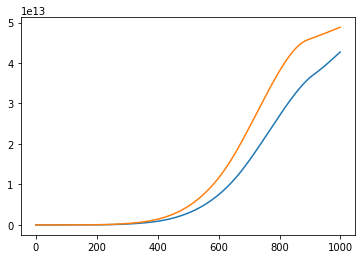

In [27]:
plt.plot(V_t[:,:, 0])

### Summary Graph

#### At a specific age, plot choices in consumption, bond and stock both in good and bad times.

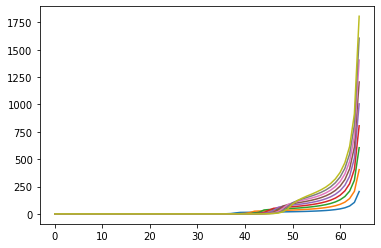

In [28]:
from matplotlib import pyplot as plt
plt.plot(C_t[100,1,:])
plt.plot(C_t[200,1,:])
plt.plot(C_t[300,1,:])
plt.plot(C_t[400,1,:])
plt.plot(C_t[500,1,:])
plt.plot(C_t[600,1,:])

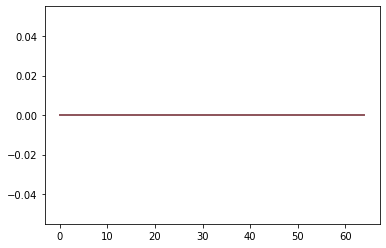

In [36]:
plt.plot(B_t[100,1,:])
plt.plot(B_t[200,1,:])
plt.plot(B_t[300,1,:])
plt.plot(B_t[400,1,:])
plt.plot(B_t[500,1,:])
plt.plot(B_t[600,1,:])

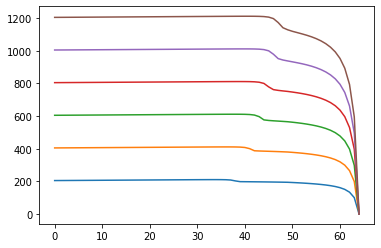

In [37]:
plt.plot(K_t[100,1,:])
plt.plot(K_t[200,1,:])
plt.plot(K_t[300,1,:])
plt.plot(K_t[400,1,:])
plt.plot(K_t[500,1,:])
plt.plot(K_t[600,1,:])

### simulation part

In [68]:
import quantecon as qe
def mc_sample_path(P, x0=None, sample_size=1000):

    # set up
    P = np.asarray(P)
    X = np.empty(sample_size, dtype=int)

    # Convert each row of P into a cdf
    n = len(P)
    P_dist = [np.cumsum(P[i, :]) for i in range(n)]

    # draw initial state, defaulting to 0
    if x0 is not None:
        X_0 = qe.random.draw(np.cumsum(x0))
    else:
        X_0 = 0

    # simulate
    X[0] = X_0
    for t in range(sample_size - 1):
        X[t+1] = qe.random.draw(P_dist[X[t]])

    return X

def action(t, w, s):
    c = interp1d(wgrid, C_t[:,s,t], kind = "linear", fill_value = "extrapolate")(w)
    b = interp1d(wgrid, B_t[:,s,t], kind = "linear", fill_value = "extrapolate")(w)
    k = interp1d(wgrid, K_t[:,s,t], kind = "linear", fill_value = "extrapolate")(w)
    return (c,b,k)
    
# Define the transtiion of state 
def fixTransition(w, s, s_next, a):
    c, b, k = a
    # collect possible next state (w_next, s_next) with probability prob
    Z_next = []
    prob = []
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    r_bond = r_f[int(s)]
    r_stock = r_m(s,s_next)
    w_next = b*(1+r_bond) + k*(1+r_stock)
    return w_next

In [74]:
# importing pandas as pd  
simulations = 1000
for sim in range(simulations):
    if sim%100 == 0:
        print(sim)
    # simulate an agent age 15 starting with wealth of 10
    w = 10
    wealth = []
    Consumption = []
    Bond = []
    Stock = []
    econState = mc_sample_path(P, sample_size=T_max-T_min+1)
    for t in range(len(econState)-1):
        wealth.append(w)
        s = econState[t]
        s_next = econState[t+1]
        a = action(t, w, s)
        Consumption.append(a[0])
        Bond.append(a[1])
        Stock.append(a[2])
        w = fixTransition(w,s,s_next, a)
    # dictionary of lists  
    dictionary = {'wealth': wealth,
                  'Consumption': Consumption, 
                  'Bond': Bond, 
                  'Stock': Stock}  
    if sim == 0:
        df = pd.DataFrame(dictionary) 
    else:
        df = df + pd.DataFrame(dictionary) 

0
100
200
300
400
500
600
700
800
900


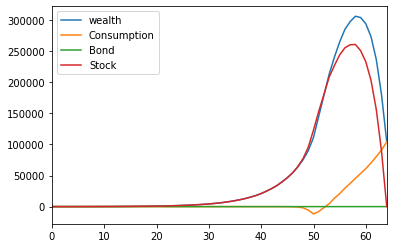

In [78]:
(df/simulations).plot()

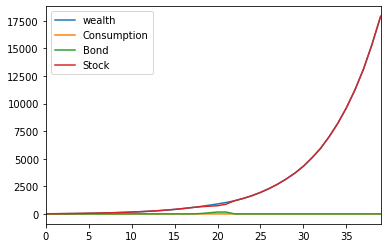

In [77]:
(df/simulations)[:40].plot()

In [13]:
# cRatio = df.Consumption/df.wealth
# cRatio.plot()

In [14]:
# bRatio = df.Bond/df.wealth
# bRatio.plot()

In [15]:
# sRatio = df.Stock/df.wealth
# sRatio.plot()